In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from vqls import *
from utils import *

label = 'relu'
nq = 4
n_step = 16

file_path = f"results_{label}_{nq}.json"

In [18]:
df = pd.read_json(file_path)
df.head()

,Condition number,norm(yk),training_cost,exe_time,in_train_weights,RSS_q,RSS_h,seed
0,12730.232709,1.046311,"[0.4771129396, 0.4542505499, 0.4495125291, 0.4...",120942.523607,"[[0.4843168531, 2.3249346899, 0.8272285173, 1....",5.329755,4.669781,12
1,12730.232709,1.046311,"[0.43838630640000004, 0.3788885008, 0.47070683...",95534.714161,"[[0.7807175907, 1.4136394771, 1.2910086078, 0....",2.054769,1.748778,33
2,12730.232709,1.046311,"[0.4626666701, 0.46884439850000004, 0.42662472...",145357.089480,"[[3.038013838, 1.7191808138, 3.0557780395, 2.2...",2.039573,1.732888,4
3,12730.232709,1.046311,"[0.4467984163, 0.4098396192, 0.453916125300000...",187569.926517,"[[2.0343416195, 1.5932577347999999, 1.65983339...",2.055160,1.752819,88
4,12730.232709,1.046311,"[0.3801968221, 0.4099021594, 0.4399620641, 0.4...",140572.945544,"[[2.7439593952, 3.042760231, 2.7306551821, 1.6...",5.318409,4.653024,8


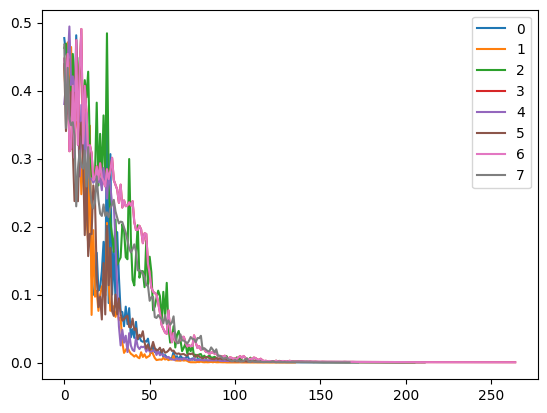

In [19]:
#Visualize training cost and obtain best performing epoch
argM = []
for i,item in enumerate(df["training_cost"].values):
    argM.append(np.argmin(item))
    plt.plot(item, label = i)
plt.legend()

In [20]:
## experimental specific settings


sigmoid 2.5604094245702336
tanh 2.3134308843812557
elu 1.5109225878099715
relu 1.0751889368850482
sin 2.5


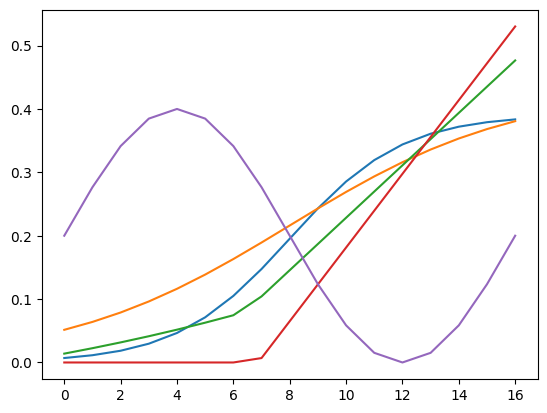

In [36]:

func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func_list = list(func_out.keys())
func_dict = {'sigmoid': .0,'tanh': 1.0,'elu':.12, 'relu':.0, 'sin':.0}

pnq = {'3':(3,8),
        '4':(4,16)}
columns=['function', 'nq', 'knot', 'training cost', 'time(s)', 'weights', 'RSS_h', 'RSS_q' ]
tot = []

#############################################################################################
###################################### System Preparatio and _sin_#################
#############################################################################################
for label in func_list:
    lower = 0. 
    upper = 1. 
    f_i = func_dict[label]
    scaled=True
    func = func_out[label]
    x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
    xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
    y = [func(value,f_i) for value in x]

    if scaled:
        norm = np.linalg.norm(y)
        print(label, norm)
        y = y / norm
    plt.plot(y)
    tck=splrep(x,y,k=1) #coeffs
    matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled)


#############################################################################################
################################# VQLS and Linear Prob. Solving #############################
#############################################################################################


k_numb=np.linalg.cond(np.array(matrix))

vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 


beta_classic                 : [ 5.00000000e-01  8.84817516e-01 -1.83692040e+00  1.84767757e+01
 -6.90294615e+01  1.93570748e+02 -3.84342457e+02  5.78498417e+02
 -6.59846857e+02  5.78108583e+02 -3.85062210e+02  1.92631586e+02
 -7.00441143e+01  1.75416183e+01 -2.55052482e+00  5.00000000e-01]


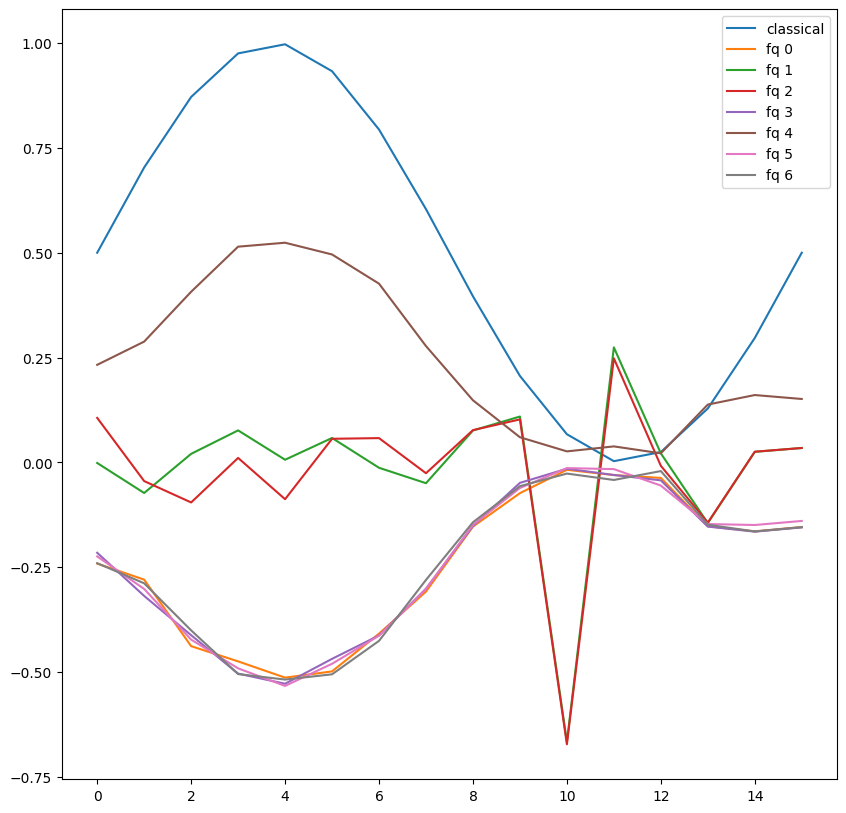

In [6]:
c = np.linalg.solve(matrix,vector)
print('beta_classic                 :',c)
plt.figure(figsize=(10,10))

y_c=np.dot(matrix,c) #classic
plt.plot(range(len(y_c)),y_c, label="classical")

for i,item in enumerate(df['in_train_weights']):
  weights = item[argM[i]]
  q = vqls_circuit.solution(weights).real
  y_q=np.dot(matrix,q) #hybrid
                        #Quantum

  y_fq=[]
  for el in matrix:
    y_fq.append(vqls_circuit.direct_prod2(weights,el))

  #plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
  plt.plot(range(len(y_fq)),y_fq, label= f"fq {i}")
plt.legend()

In [7]:
best = np.argmin(df['RSS_q'])
weights = df['in_train_weights'][best][argM[best]]


In [8]:
print()


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Quantum State (0.23259120950714735+0j)
[0.         0.93333333 0.06666667 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Quantum State (0.28798077618628964+0j)
[0.         0.         0.86666667 0.13333333 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Quantum State (0.4068777753181066+0j)
[0.  0.  0.  0.8 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
Quantum State (0.5144647713707141+0j)
[0.         0.         0.         0.         0.73333333 0.26666667
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Quantum State (0.5238780494045958+0j)
[0.         0.         0.         0.         0.         0.66666667
 0.33333333 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Quantum State (0.495

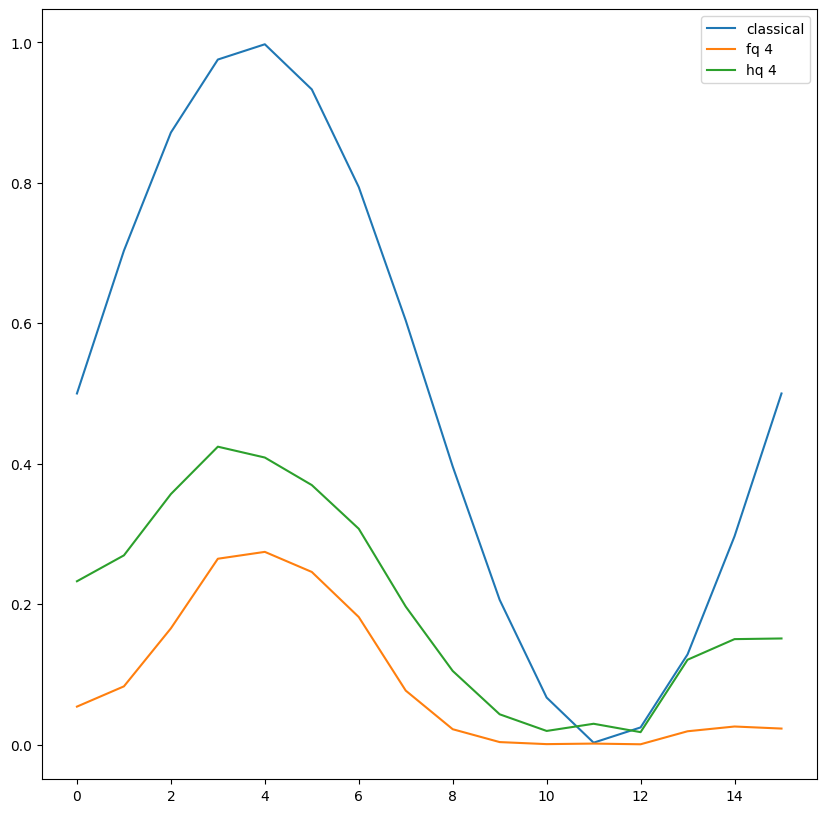

In [13]:
#Best performing model based on RSS
best = np.argmin(df['RSS_q'])


weights = df['in_train_weights'][best][argM[best]]
q = vqls_circuit.solution(weights).real
y_q=np.dot(matrix,q) #hybrid
                  #Quantum
plt.figure(figsize=(10,10))
plt.plot(range(len(y_c)),y_c, label="classical")

y_fq=[]
for el in matrix:
  print(el)
  y_fq.append(vqls_circuit.direct_prod2(weights,el, visualize=True))

#plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
#plt.plot(range(len(y_fq)),np.abs(y_fq), label= f"fq abs {best}")
#plt.plot(range(len(y_fq)),np.abs(y_q), label= f"hq abs {best}")
plt.plot(range(len(y_fq)),np.power((y_fq),2), label= f"fq {best}")
plt.plot(range(len(y_fq)),(y_q), label= f"hq {best}")
plt.legend()
#plt.savefig(f'{file_path[:-5]}.png')
plt.show()

## Print approximation of best models


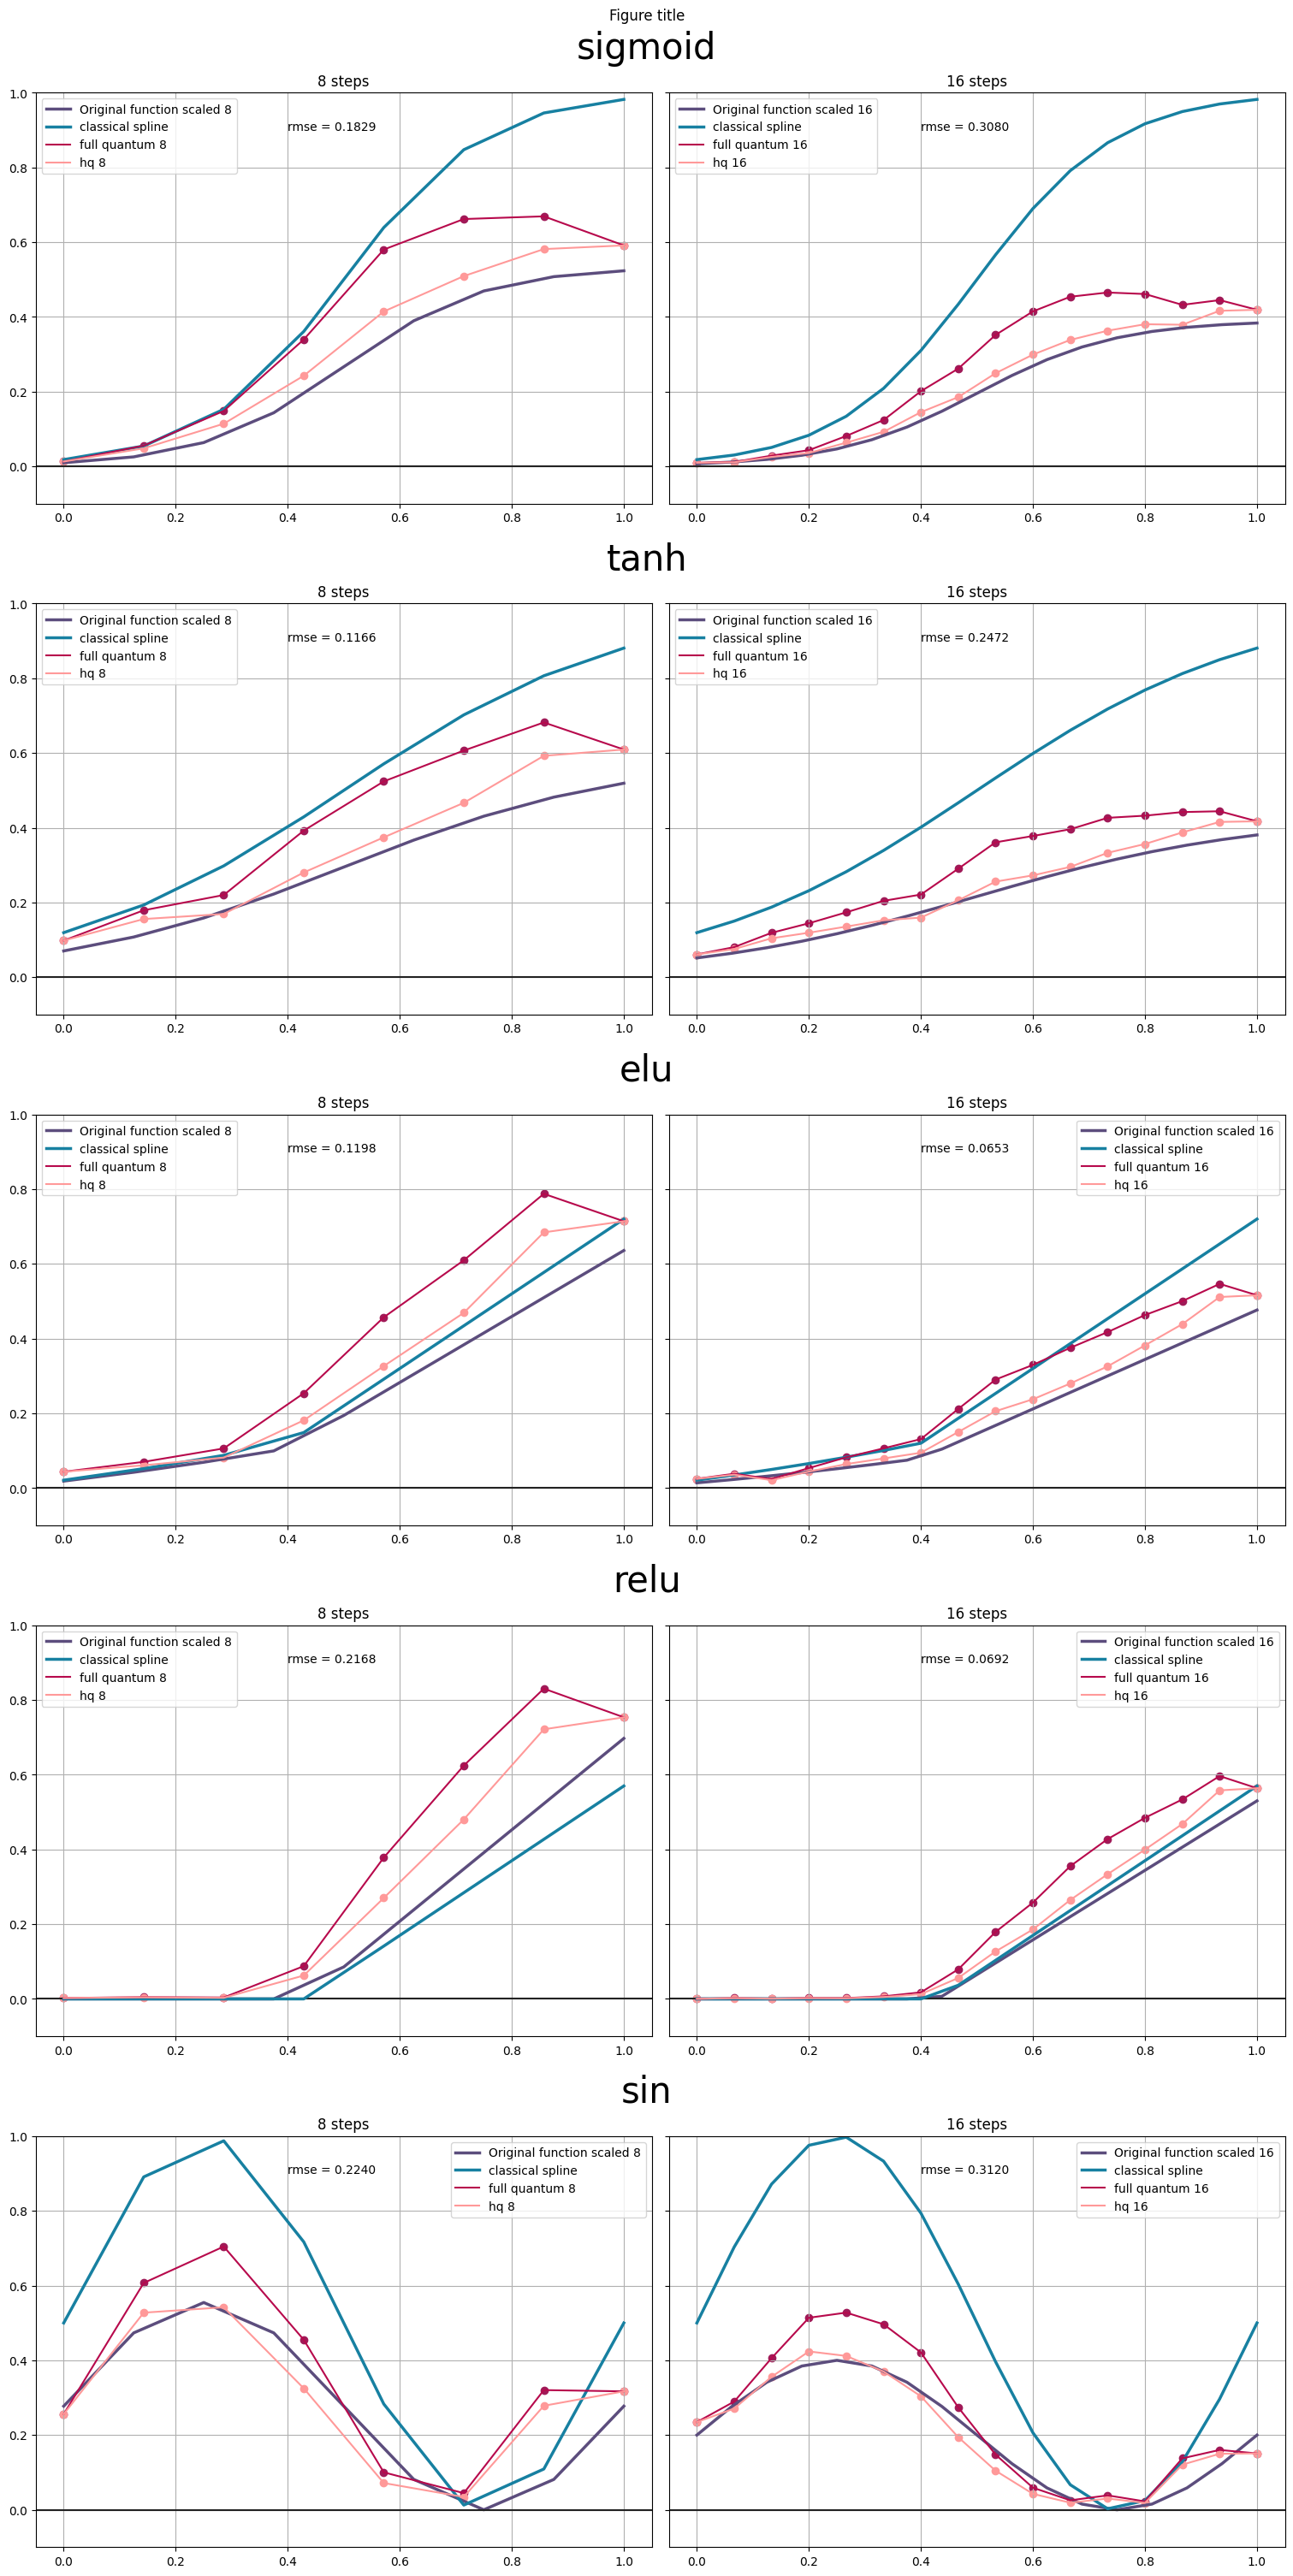

In [23]:
func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func_list = list(func_out.keys())
func_dict = {'sigmoid': .0,'tanh': 1.0,'elu':.12, 'relu':.0, 'sin':.0}

pnq = {'3':(3,8),
        '4':(4,16)}
columns=['function', 'nq', 'knot', 'training cost', 'time(s)', 'weights', 'RSS_h', 'RSS_q' ]
tot = []
for flab, fun in func_out.items():
    for nq, knot in  pnq.values():
        file_path = f"results_{flab}_{nq}.json"
        df = pd.read_json(file_path)
        best = np.argmin(df['RSS_q'])
        #if knot == 16 and flab == "sin":
        #    best = 0
        if knot == 16 and "relu" == flab:
            best = 0
        weights = df['in_train_weights'][best][-1]
        tot.append([flab, nq, knot, df.training_cost[best], df.exe_time[best], weights,df.RSS_h[best], df.RSS_q[best] ])
    
df = pd.DataFrame(tot, columns=columns)
df

fig = plt.figure(constrained_layout=True, figsize=(15,30))
fig.suptitle('Figure title')
axE = fig.subfigures(5,1,  )
j = 0
rss=[]
for flab, fun in func_out.items():
    axE[j].suptitle(f'{flab}',fontsize=30)

    ax = axE[j].subplots(nrows=1, ncols=2, sharey=True,)

    ax[0].set_ylim(-0.1,1)

    j-=-1
    dl = df[df['function'] == flab]
    dl.reset_index(drop=True, inplace=True)
    #x = np.linspace(0, 1, 16).tolist() 
    #for el in x:
    #    plt.axvline(el, color = '#993333', alpha=0.2)
    #x = np.linspace(0, 1, 8).tolist() 
    #for el in x:
    #    plt.axvline(el, color = '#b300b3', alpha=0.2)
    for i, el in dl.iterrows():
        lower = 0. 
        upper = 1. 
        f_i = func_dict[flab]
        scaled=False    
        label = flab
        n_step = el.knot
        x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
        xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
        y = [fun(value,f_i) for value in x]

        tck=splrep(x,y,k=1) #coeffs
        norm = np.linalg.norm(y)
        y = y / norm
        ax[i].plot(np.linspace(0,1,len(y)),y, label=f"Original function scaled {n_step}", color = '#5c4d7d',linewidth=2.5)

        ax[i].axhline(0, color="#222222")
        matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled)

        vqls_circuit = VQLS(matrix,v_norm,el['nq'],opt='COBYLA') 

        c = np.linalg.solve(matrix,vector)

        y_c=np.dot(matrix,c) #classic
        ax[i].plot(np.linspace(0,1,len(y_c)),y_c, label="classical spline", color = '#1780a1',linewidth=2.5)

        y_fq=[]
        q = vqls_circuit.solution(el['weights']).real
        y_q=np.dot(matrix,q) #hybrid
                        #Quantum

        for a in matrix:
            y_fq.append(vqls_circuit.direct_prod2(el['weights'],a))
        rssss = math.sqrt(np.square(np.subtract(y_c,np.abs(y_fq))).mean())
        rss.append(rssss)
        colorl = '#b7094c'
        colors = '#a01a58'
        colorh = '#ff9999'
        ax[i].plot(np.linspace(0,1,len(y_fq)),np.abs(y_fq),label= f"full quantum {n_step}", color=colorl)
        ax[i].scatter(np.linspace(0,1,len(y_fq)),np.abs(y_fq), color=colors)
        ax[i].scatter(np.linspace(0,1,len(y_fq)),np.abs(y_q),  color=colorh)
        ax[i].plot(np.linspace(0,1,len(y_fq)),np.abs(y_q), label= f"hq {n_step}", color=colorh)
        ax[i].text(0.4,0.9,f"rmse = {rssss:.4f}")
        ax[i].set_title(f'{n_step} steps')
        ax[i].legend()
        ax[i].grid()
plt.savefig(f'full_plots.png')
plt.show()

